**NOTE:** This notebook uses dimensionless equations and quantities. My Overleaf notes detail the exact scaling relations.

In [1]:
# import packages
import numpy as np
import scipy.integrate as integrate
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# Galactic phase mixing animation

Let's plot the time evolution of a first-order perturbation: Essentially, every particle follows a circular orbit with frequency $\Omega(J)$. This recreates the Gaia snail shape.

In [2]:
# define Omega
def Omega(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    Here, we interpolate between the low-J and high-J regimes for Omega.
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    In this function, J is dimensionless. J=1 corresponds to sigma*z_0 in
    physical units.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom

Below is an approximate function for converting from action-angle to Cartesian coordinates. Within the next couple weeks, I plan to properly (i.e., numerically) evaluate the conversion between these two coordinate systems.

In [6]:
## basic function for converting (thetas, Js) to (x_vals, y_vals)

def pol2cart_meshgrid(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid in Cartesian coordinates.
    
    '''
    
    xs = np.sqrt(Js) * np.cos(thetas)
    ys = np.sqrt(Js) * np.sin(thetas)
    
    return xs, ys

In [7]:
# define phase mixing (i.e., a first-order phase mixing solution for n=1)
def delta_f_phase_mixing(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a generic perturbation 
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

In [8]:
# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

In [16]:
# define ts, thetas, and Js; and, corresponding Cartesian coords
# time range
tmin = 0
tmax = 100
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# angle
theta_min = 0
theta_max = 2*np.pi
num_thetas_sampled = 100
theta_step = theta_max/num_thetas_sampled

# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# from eq. 7, J is roughly prop to v*z.
J_min = 0
J_max = 20
J_step = 0.05

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, J_step)
# thetas, Js are generated from a meshgrid 
thetas, Js = np.meshgrid(thetas, Js) # both thetas and Js has shape (# of Js, # of thetas)

x_vals, y_vals = pol2cart_meshgrid(thetas, Js)


In [ ]:
## plot phase mixing at 1 timepoint
# plt.clf()
# fig, ax = plt.subplots(1,1,figsize=(12,10))

# # test that we can plot delta_f at a given t
# Z = delta_f_phase_mixing(thetas, Js, 0)

# im = ax.pcolormesh(x_vals,y_vals,Z,cmap=cm.coolwarm, animated=True, shading='auto')

# fig.colorbar(im, ax=ax)

# ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
# ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")
# ax.set_title("$\delta f$")

# plt.show()

<ipython-input-17-bdd299d0a2ca>:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True, shading='auto')


t = 0.0
Elapsed t: 0.1 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 10.0
Elapsed t: 5.2 seconds
t = 20.0
Elapsed t: 9.9 seconds
t = 30.0
Elapsed t: 15.0 seconds
t = 40.0
Elapsed t: 19.8 seconds
t = 50.0
Elapsed t: 24.7 seconds
t = 60.0
Elapsed t: 30.0 seconds
t = 70.0
Elapsed t: 35.1 seconds
t = 80.0
Elapsed t: 40.2 seconds
t = 90.0
Elapsed t: 45.2 seconds
t = 100.0
Elapsed t: 49.8 seconds


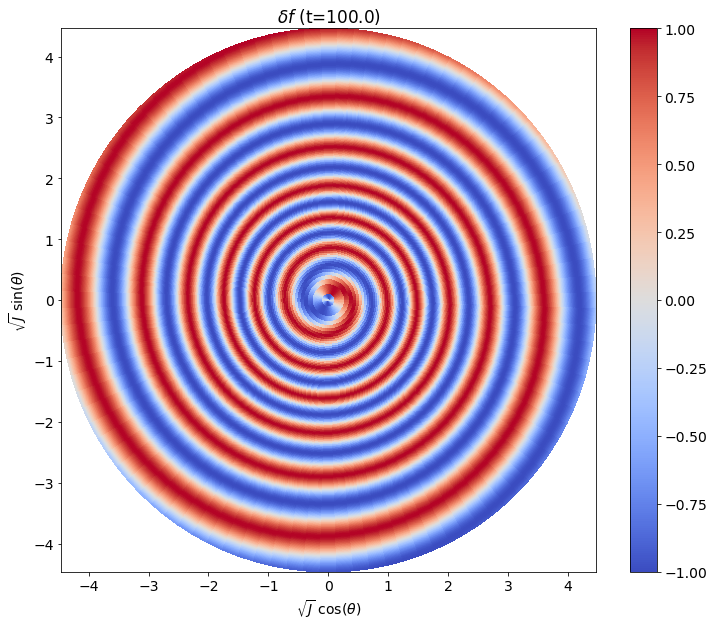

In [17]:
## galactic phase mixing animation
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f_phase_mixing(thetas, Js, 0)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True, shading='auto')
fig.colorbar(quad1, ax=ax)

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    # global im
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    Z = delta_f_phase_mixing(thetas, Js, t)
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f$ (t=' + str(t) + ')')
    
    return quad1,


ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("Gaia_pm_polar_temp.mp4")

# Galactic echo animation

In [ ]:
## define the slab Hamiltonian, f0, and f0's derivatives